# Demand Forecasting Analysis

## Introduction
**Objective**: Analyse past 2 years of e-commerce operations data, in order to build and optimize a forecasting model for the next 4, 6 and 8 weeks, specific to:
-  Daily Order Volume
- Daily customer care tickets

## Initiation

### Import Libraries

In [7]:
# Basic imports for data analysis
from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Set pandas display options for full visibility
pd.set_option('display.max_columns', None)

# Imports for visualization
import matplotlib.pyplot as plt
import seaborn as sns 



### Import Dataset

In [ ]:
# Import dataset
repo_root = Path.cwd().parent
df = pd.read_csv(repo_root / "data" / "daily_demand.csv")

In [9]:
df.head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion
0,2023-01-01,613,1586,44791.35,78,1,1,0
1,2023-01-02,598,1026,50143.22,49,0,0,0
2,2023-01-03,522,1455,38737.17,61,0,0,0
3,2023-01-04,519,1287,25786.90,54,0,0,0
4,2023-01-05,609,1145,41630.79,54,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   730 non-null    object 
 1   orders                 730 non-null    int64  
 2   units_sold             730 non-null    int64  
 3   revenue                730 non-null    float64
 4   customer_care_tickets  730 non-null    int64  
 5   is_weekend             730 non-null    int64  
 6   is_holiday             730 non-null    int64  
 7   is_promotion           730 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 45.8+ KB


We don't have any NaNs in our dataset.

In [ ]:
# Summary Statistics for table data
df.describe(include= 'all')

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion
count,730,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
unique,728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2024-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,926.845205,2119.484932,59922.678534,97.912329,0.286301,0.027397,0.078082
std,NaN,445.959697,1092.318130,30882.044720,56.829714,0.452342,0.163350,0.268485
min,NaN,119.000000,292.000000,8477.870000,10.000000,0.000000,0.000000,0.000000
25%,NaN,671.250000,1453.250000,41525.125000,65.000000,0.000000,0.000000,0.000000
50%,NaN,823.000000,1876.500000,53336.095000,84.000000,0.000000,0.000000,0.000000
75%,NaN,1075.750000,2479.500000,70341.242500,111.750000,1.000000,0.000000,0.000000


### Data Cleaning

#### Correction of date format

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   730 non-null    datetime64[ns]
 1   orders                 730 non-null    int64         
 2   units_sold             730 non-null    int64         
 3   revenue                730 non-null    float64       
 4   customer_care_tickets  730 non-null    int64         
 5   is_weekend             730 non-null    int64         
 6   is_holiday             730 non-null    int64         
 7   is_promotion           730 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 45.8 KB


- Other data columns are in the correct format.
- Headers are named conveniently and don't require changes.

#### Check for duplicates

In [14]:
df.duplicated().sum()

0

- No duplicate values for entire rows observed.

## Outlier Detection and Analysis

### Outlier Identification

#### IQR Approach

In [15]:
# Running a loop to create variables for 75th and 25th Percentile, based on which we derive the Inter-Quartile Range (IQR). This would thereafter be 
# used to derive upper and lower limits as classification of outliers.
cols = ["orders", "units_sold", "revenue", "customer_care_tickets"]

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    globals()[f"perc25_{col}"] = q1
    globals()[f"perc75_{col}"] = q3
    globals()[f"iqr_{col}"] = iqr
    globals()[f"upper_limit_{col}"] = q3 + 1.5 * iqr
    globals()[f"lower_limit_{col}"] = q1 - 1.5 * iqr

#### z-score Approach

In [16]:
# Generating z-scores for numerical columns
df_z = df.copy()
for c in cols:
    df_z[f"zscore_{c}"] = stats.zscore(df_z[c])

### Outlier Visualization

#### IQR Outlier visualization

In [33]:
# Create flag for outliers
df_iqr = df.copy()
df_iqr['is_outlier_orders'] = df_iqr['orders'].apply(
    lambda x: 1 if x > upper_limit_orders or x < lower_limit_orders else 0
)
df_iqr['is_outlier_units_sold'] = df_iqr['units_sold'].apply(
    lambda x: 1 if x > upper_limit_units_sold or x < lower_limit_units_sold else 0
)
df_iqr['is_outlier_revenue'] = df_iqr['revenue'].apply(
    lambda x: 1 if x > upper_limit_revenue or x < lower_limit_revenue else 0
)
df_iqr['is_outlier_customer_care_tickets'] = df_iqr['customer_care_tickets'].apply(
    lambda x: 1 if x > upper_limit_customer_care_tickets or x < lower_limit_customer_care_tickets else 0
)


In [34]:
# Quick check on order outliers
df_iqr[df_iqr['is_outlier_orders'] == 1].head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
9,2023-01-10,1877,2929,156115.11,222,0,0,0,1,0,1,1
72,2023-03-14,1815,5112,139880.71,187,0,0,0,1,1,1,1
127,2023-05-07,2431,6294,188250.21,282,0,0,0,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,1,1,1,1
185,2023-07-04,1720,2621,98694.02,286,0,1,0,1,0,0,1


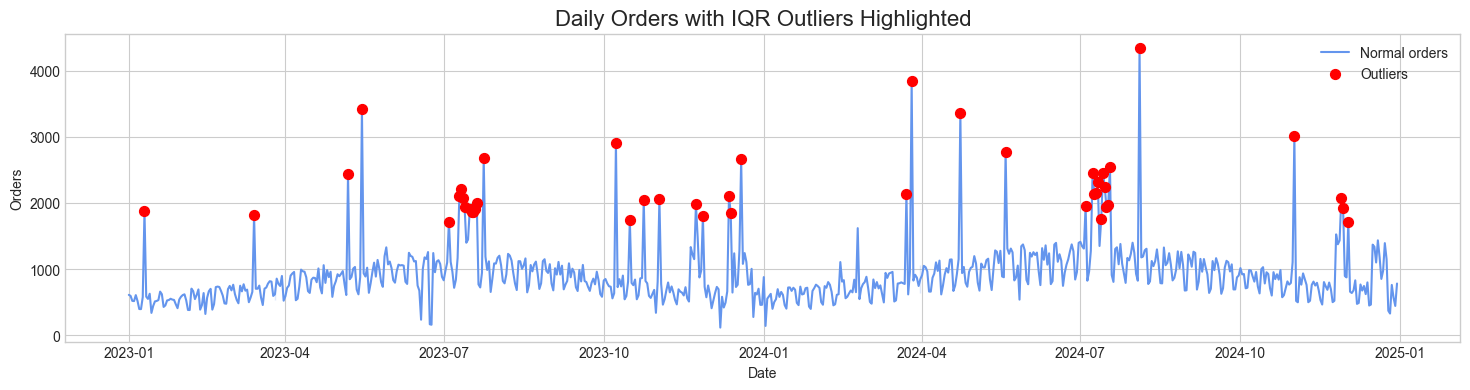

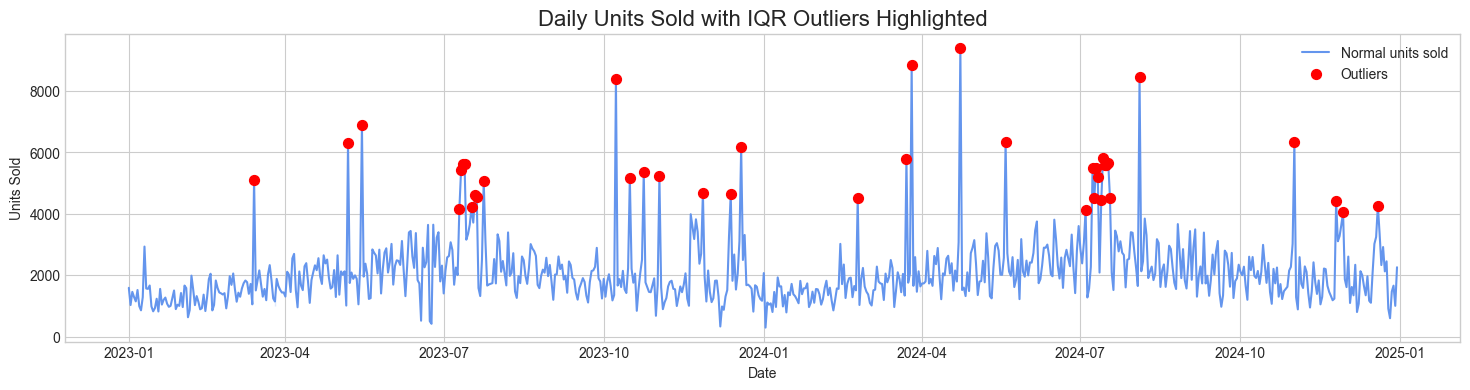

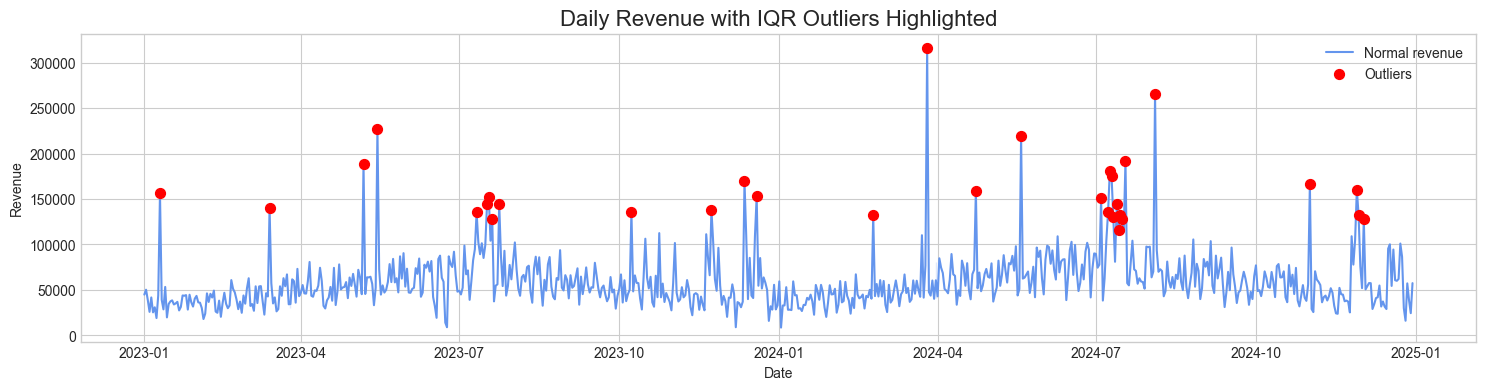

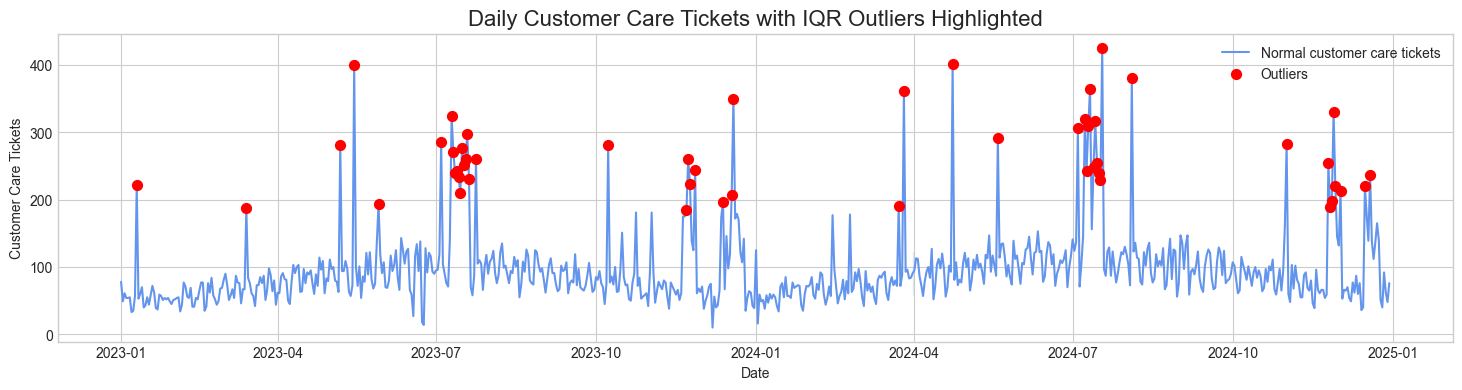

In [ ]:
# Visualize IQR Outliers using Seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Loop through each column to create a plot
for column in cols:
    fig, ax = plt.subplots(figsize=(18, 4))

    # Plot the main time series line for the current column
    sns.lineplot(
        x='date', 
        y=column, 
        data=df_iqr, 
        ax=ax, 
        label=f'Normal {column.replace("_", " ")}', 
        color='cornflowerblue'
    )

    # Identify and plot the outliers for the current column
    outlier_flag_column = f'is_outlier_{column}'
    outliers_df = df_iqr[df_iqr[outlier_flag_column] == 1]
    
    ax.scatter(
        outliers_df['date'], 
        outliers_df[column], 
        color='red', 
        s=50, 
        label='Outliers',
        zorder=5  # zorder ensures points are drawn on top of the line
    )

    # Customize the plot with dynamic titles and labels 
    ax.set_title(f'Daily {column.replace("_", " ").title()} with IQR Outliers Highlighted', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{column.replace("_", " ").title()}')
    ax.legend()

    # Display the plot for the current column 
    plt.show()

#### z-score Outlier visualization

In [50]:
df_zout = df_z.copy()

for col in cols:
    zscore_column = f'zscore_{col}'
    outlier_flag_column = f'is_outlier_{col}'
    
    # Apply the lambda function to each z-score column
    df_zout[outlier_flag_column] = df_zout[zscore_column].apply(
        lambda x: 1 if (x > 3) or (x < -3) else 0
    )

# Display the first few rows to show the results
df_zout[df_zout['is_outlier_units_sold'] == 1].head()

,date,orders,units_sold,revenue,customer_care_tickets,is_weekend,is_holiday,is_promotion,zscore_orders,zscore_units_sold,zscore_revenue,zscore_customer_care_tickets,is_outlier_orders,is_outlier_units_sold,is_outlier_revenue,is_outlier_customer_care_tickets
127,2023-05-07,2431,6294,188250.21,282,0,0,0,3.375162,3.824323,4.158258,3.241506,1,1,1,1
135,2023-05-15,3415,6885,227051.86,400,0,0,0,5.583152,4.365745,5.415567,5.319309,1,1,1,1
192,2023-07-11,2204,5431,135361.40,271,0,0,1,2.865798,3.033718,2.444477,3.047813,0,1,0,1
193,2023-07-12,2075,5617,102404.97,239,0,0,1,2.576336,3.204115,1.376574,2.484341,0,1,0,0
194,2023-07-13,1939,5607,89198.87,242,0,0,1,2.271167,3.194954,0.948650,2.537167,0,1,0,0


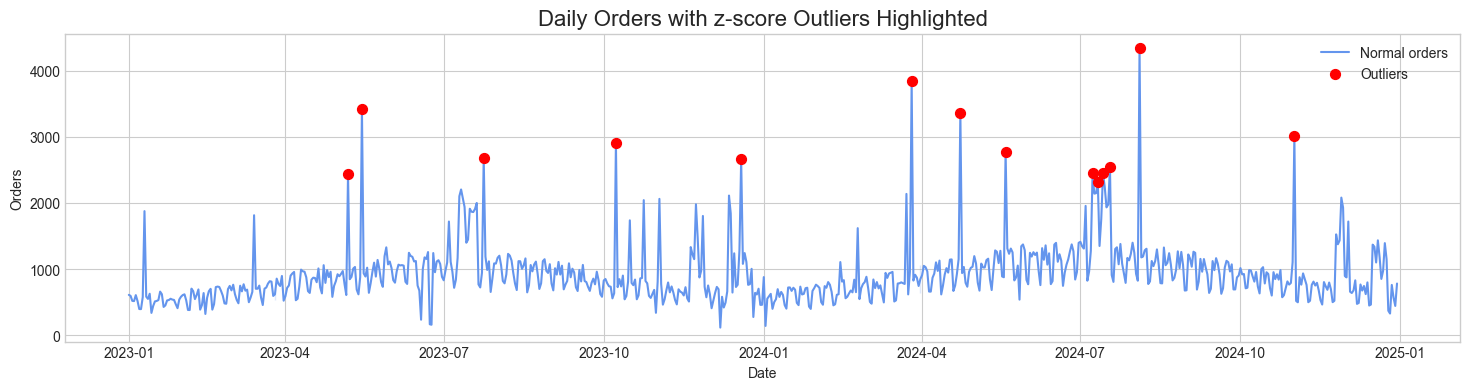

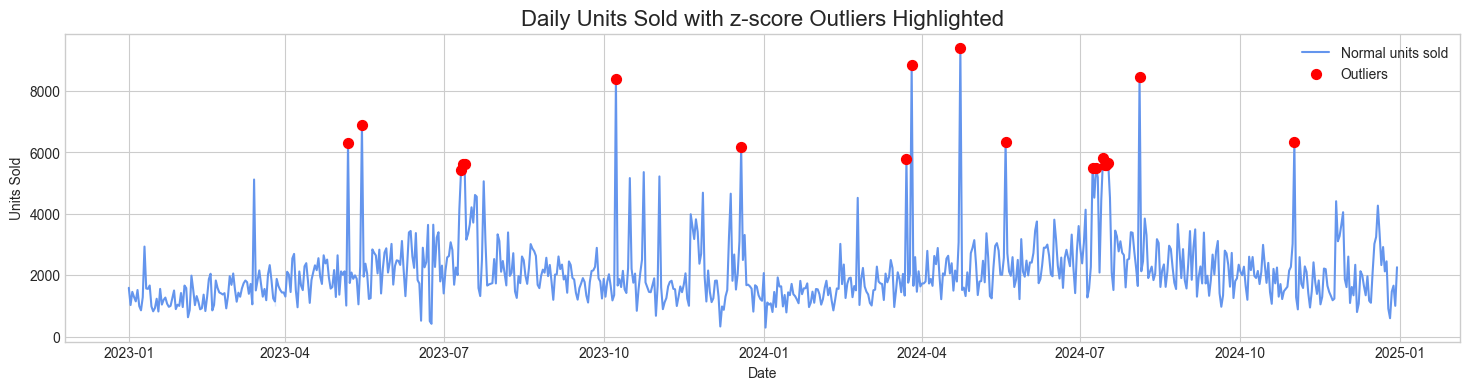

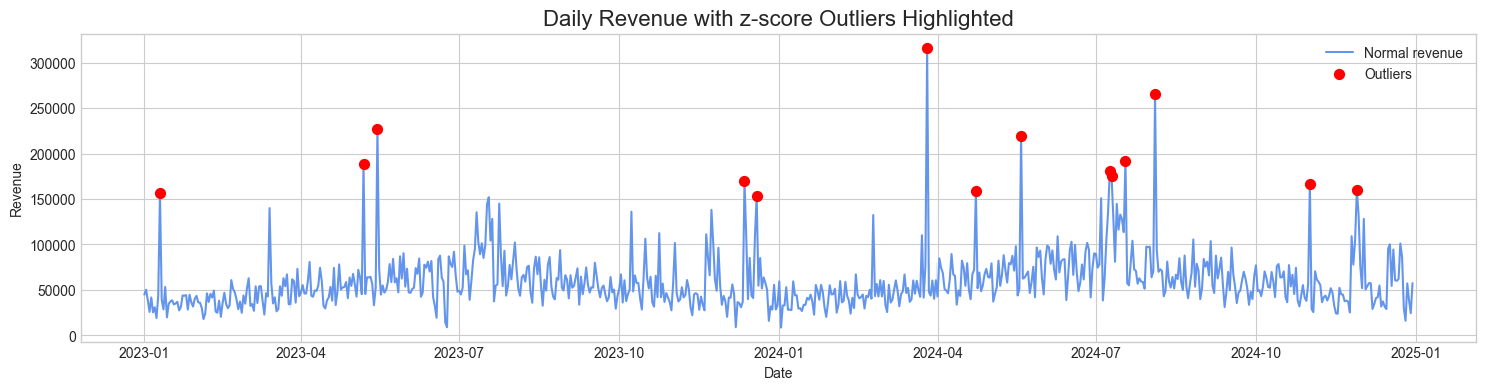

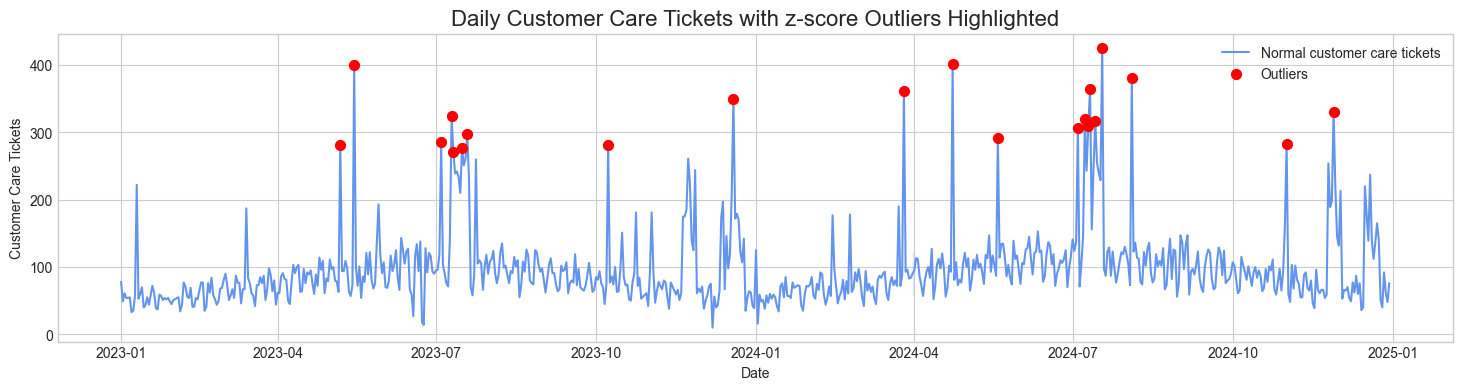

In [51]:
# Visualize z-score Outliers using Seaborn
plt.style.use('seaborn-v0_8-whitegrid')

# Loop through each column to create a plot
for column in cols:
    fig, ax = plt.subplots(figsize=(18, 4))

    # Plot the main time series line for the current column
    sns.lineplot(
        x='date', 
        y=column, 
        data=df_zout, 
        ax=ax, 
        label=f'Normal {column.replace("_", " ")}', 
        color='cornflowerblue'
    )

    # Identify and plot the outliers for the current column
    outlier_flag_column = f'is_outlier_{column}'
    outliers_df = df_zout[df_zout[outlier_flag_column] == 1]
    
    ax.scatter(
        outliers_df['date'], 
        outliers_df[column], 
        color='red', 
        s=50, 
        label='Outliers',
        zorder=5  # zorder ensures points are drawn on top of the line
    )

    # Customize the plot with dynamic titles and labels 
    ax.set_title(f'Daily {column.replace("_", " ").title()} with z-score Outliers Highlighted', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'{column.replace("_", " ").title()}')
    ax.legend()

    # Display the plot for the current column 
    plt.show()

### Observation Summary (Handling of Outliers)

- Based on the visualizations from IQR and z-score approach, we generally observe fewer outliers using the z-score approach.  
- We will check for the distribution of order values to see if we have a close to normal distribution. 

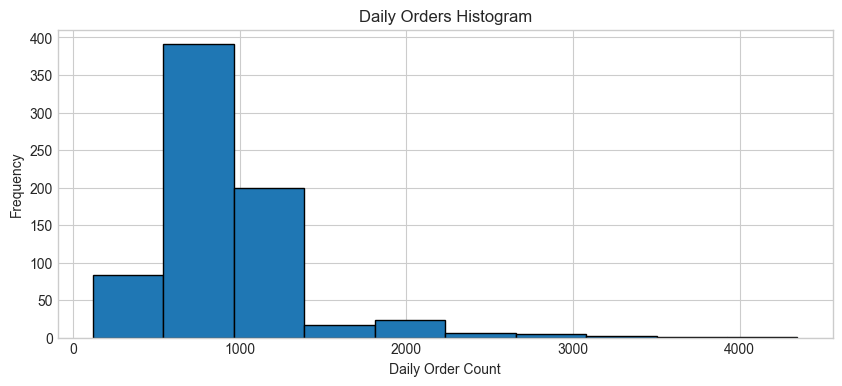

In [ ]:
# Plot a histogram of orders
plt.figure(figsize= (10,4))
df['orders'].hist(edgecolor= 'black')
plt.xlabel('Daily Order Count')
plt.ylabel('Frequency')
plt.title('Daily Orders Histogram')
plt.show()

The distribution of orders seems skewed to the right, in which case, z-score approach wouldn't be effective in identifying outliers. We'll use the outliers identified using IQR approach going forward.

## Feature Engineering

### Create Relevant Feature

### Correlation Analysis

## Data Preparation 

### Data Transformation

### Set up Training & Testing Data

## Model Build 

### Model 1

### Model 2

## Model Evaluation